In [913]:
# Imports
import numpy as np
import random # todo - replace with custom implementation
import scipy
import scipy.stats as stats
rdm = random.random


In [914]:
# Probability Parameters
p_decelerate = .20 # prob. car decelerates
p_change     = 1 # prob. car changes lanes
p_exit       = .05 # prob. car turns off corridor
p_enter      = .05  # prob. car turns onto corridor
p_left       = .50 # prob. car chooses left lane to swap if both are available
p_fill       = .4  # prob. that road section starts with car
#p_add_car    = .85  # prob. that car is added to corridor each time step
p_add_car    = 1

In [915]:
# Parameters
LENGTH        = 500
#LENGTH       = 450
LANES         = 3
INTERSECTIONS = 4
TIME_STEPS    = 3000
MOD           = 100 # light is red every MOD step
MAXMAX        = 6  # max max speed

# Internal use only
data_type = np.int64
data_size = 3

# Numpy seed
#np.random.seed()

In [916]:
# By defining the following two functions, we can model different speed 
# distributions later
def get_max_v(): 
    r = rdm()
    if r < .6:
        return MAXMAX 
    elif r < .8 :
        return MAXMAX-1
    else:
        return MAXMAX-2


# Unit test for get_max_v
def get_max_v_unit():
    m = get_max_v()
    assert m <= MAXMAX
    assert m > get_starting_v()
    assert m > 0
    
def get_starting_v(): 
    return 3

# Unit test for get_starting_v
def get_starting_v_unit():
    m = get_starting_v()
    assert m >= 0
    assert m <= MAXMAX

# For now, we will assume the corridors are equally spaced. Later, 
# we can spread them out to match reality
def get_intersections(num, corridor_length):
    a = dict()
    for i in range(num):
        i = (i+1) * (corridor_length / (num+1))
        i = np.int64(i)
        a[i] = dict()
        a[i]['state'] = 'green'
    a = initialize_lights(a)
    return a

# Unit test for get_interesctions
def get_intersections_unit(num, corridor_length):
    u = get_intersections(num, corridor_length)
    assert len(u) == num
    
    keys = np.array(list(({int(k) for k in u.keys()})))
    assert np.array((keys < corridor_length)).all()
    assert np.array((keys >0)).all()
        
# Fill spaces in corridor with cars with probability p_fill
def initialize_corridor(length, lanes, data_size, p_fill):
    corridor_shape = (length, lanes, data_size)
    new = np.zeros(corridor_shape, dtype=data_type)
    (length, lanes, _) = new.shape
    for i in range(length):
        for j in range(lanes):
            if rdm() >= p_fill:
                continue
            new[i,j,0] = get_starting_v()
            new[i,j,1] = get_max_v()
            
    return new

# Unit test for initialize_corridor
def initialize_corridor_unit(length, lanes, data_size, p_fill):
    u = initialize_corridor(length, lanes, data_size, p_fill)
    assert u.any()

def invg():
    x = scipy.stats.invgamma.rvs(a=2.04650116555549, loc=-632.9022782513587, scale=3712.0385450624117,size=1)
    return scipy.stats.invgamma.cdf(x, a=2.04650116555549, loc=-632.9022782513587, scale=3712.0385450624117)

# Draw from some probability distribution - uniform for now - and 
# return cars (or zeros)
# p1 and p2 are the distribution parameters
# give the car a unique identifier
def get_car(dist, p1=.1, p2=0, cid = -1):
    if dist == "UNIFORM":
        if rdm() < p1:
            v = get_starting_v()
            max_v = get_max_v()
            if cid == -1:
                car_id = np.random.randint(low=0, high=2000000000)
            else:
                car_id = cid
            return (v, max_v, car_id)
    elif dist == "INVGAMMA":
        if invg() < p1:
            v = get_starting_v()
            max_v = get_max_v()
            if cid == -1:
                car_id = np.random.randint(low=0, high=2000000000)
            else:
                car_id = cid
            return (v, max_v, car_id)
    return (0,0,0)

def get_car_unit():
    for i in range(10):
        (u1,u2,u3) = get_car("UNIFORM", cid=123)
        assert u1 >= 0 
        assert u2 >= 1 or (u1 == 0 and u2 == 0)
        assert u3 == 123 or (u1 == 0 and u3 == 0)
        (u1,u2,u3) = get_car("INVGAMMA", cid=123)
        assert u1 >= 0 
        assert u2 >= 1 or (u1 == 0 and u2 == 0)
        assert u3 == 123 or (u1 == 0 and u3 == 0)
        
def initialize_lights(intersections):
    return intersections
                     

In [917]:
# This function sees if the cars want to changes lanes, then moves them

def step_lanechange(cur, INT, data, t):
    (length, lanes, _) = cur.shape
    new = np.zeros(cur.shape, dtype=data_type)
    if lanes < 2:
        return cur
    
    for j in range(lanes):
        pred = length + 2*MAXMAX
        for i in range(length):
            
            v = cur[i,j,0]   # current speed
            v_d = cur[i,j,1] # max speed
            
            if v_d == 0:
                #check to see if car enters intersection
                if (i in INT.keys()) and (j == 0 or j == lanes-1) and (rdm() < p_enter):
                    car = get_car("UNIFORM", p_add_car, cid=0)
                    cur[i,j,:] = car
                    new[i,j,:] = car
                continue
                        
            l = v+1
            l_o = l
            l_o_back = MAXMAX
            
            gap = 0
            gap_r = 0
            gap_r_back = 0
            gap_l = 0
            gap_l_back = 0
            occ_l = True
            occ_r = True
            
            # Check to see if car exits at intersection
            if (i in INT.keys()) and (j == 0 or j == lanes-1) and (rdm() < p_exit):
                #simply continue to delete car
                continue
                
            # Check to see if car enters at intersection
            
            
            #T1
            for ii in range(i+1,length):
                if cur[ii,j,1] == 0:
                    gap = gap + 1
                else:
                    break
            
            if j != 0:
                #T2
                for ii in range(i+1,length):
                    if cur[ii,j-1,1] == 0:
                        gap_l = gap_l + 1
                    else:
                        break
                
                #T3
                for ii in range(i-1, -1,-1):
                    if cur[ii,j-1,1] == 0:
                        gap_l_back = gap_l_back + 1
                    else:
                        break
                    
                #Check other lane not occupied
                if cur[i,j-1,1] == 0:
                    occ_l = False
                        
            if j != lanes-1:
                #T2
                for ii in range(i+1,length):
                    if cur[ii,j+1,1] == 0:
                        gap_r = gap_r + 1
                    else:
                        break
                
                #T3
                for ii in range(i-1, -1,-1):
                    if cur[ii,j+1,1] == 0:
                        gap_r_back = gap_r_back + 1
                    else:
                        break
                #Check other lane not occupied
                if cur[i,j+1,1] == 0:
                    occ_r = False
                
            
            if i + gap == length-1:
                gap = 1000000000
            if i + gap_l == length-1: 
                gap_l = 1000000000
            if i + gap_r == length-1: 
                gap_r = 1000000000
            if i - gap_l_back == 0: 
                gap_l_back = 1000000000
            if i - gap_r_back == 0: 
                gap_r_back = 1000000000
                

            can_move_left = (gap < l and gap_l > l_o and gap_l_back > l_o_back and not occ_l)
            can_move_right = (gap < l and gap_r > l_o and gap_r_back > l_o_back and not occ_r)

            #T4
            if rdm() < p_change:
                if rdm() < p_left: #check left side first
                    if can_move_left:
                        new[i,j-1,:] = cur[i,j,:]
                        continue
                    if can_move_right:
                        new[i,j+1,:] = cur[i,j,:]
                        continue
                else:                  #look right first
                    if can_move_right:
                        new[i,j+1,:] = cur[i,j,:]
                        continue
                    if can_move_left:
                        new[i,j-1,:] = cur[i,j,:]
                        continue
            new[i,j,:] = cur[i,j,:]
    
    return new
    
# Test the cars changing lanes and check that the data 
# isn't corrumpted. 
def step_lanechange_unit():
    l = 20
    data = dict()
    cur = initialize_corridor(l, 1, 3, .5)
    lights = get_intersections(1, l) 
    for i in range(1000):
        cur = step_lanechange(cur, lights, data, 1)
        assert np.amax(cur) <= MAXMAX


In [918]:
def step_movement(cur, INT, data, t):
    (length, lanes, _) = cur.shape
    new = np.zeros(cur.shape, dtype=data_type)
     
    
    for j in range(lanes):
        pred = length + 2*MAXMAX #position of last observed car
        prev_light = -1 # last seen traffic light
        for i in range(length-1,-1,-1):
                        
            v = cur[i,j,0].astype(data_type)      # current speed
            v_d = cur[i,j,1]    # max speed
            car_id = cur[i,j,2] #car id
            
            if v_d == 0:     # if max speed == 0, this cell is empty
                continue
            
            gap = pred - i - 1
            if v < v_d:
                v = v + 1               #S1
            if v > gap: 
                v = gap                 #S2
            if v > 0 and rdm() < p_decelerate:
                v = v - 1               #S3
                
            # check traffic lights
            if prev_light != -1:
                if lights[prev_light]['state'] == 'red':
                    gap_light = prev_light - i - 1
                    if v > gap_light:
                        v = gap_light   #S4
                

            if i + v < length:
                new[i+v,j,0] = v
                new[i+v,j,1] = v_d
                new[i+v,j,2] = car_id
            else:
                #car exits corridor
                if car_id != 0:
                    data[car_id]['finish'] = t
                
            pred = i
            if i in INT:
                prev_light = i
            
    return new

# Test that the cars dont's speedup too much and eventually leave the corrido
def step_movement_unit():
    l = 20
    data = dict()
    cur = initialize_corridor(l, 1, 3, .5)
    lights = get_intersections(1, l) 
    for i in range(1000):
       #cur = step_movement(cur, lights, data, 1)
        assert np.amax(cur) <= MAXMAX
    #print(cur)
    #assert(np.amax(cur) == 0)
           

In [919]:
def step_lights(lights, t, MOD):
    if t % MOD > 80 == 0:
        for k in lights.keys():
            lights[k]['state'] = 'red'
    else:
        for k in lights.keys():
            lights[k]['state'] = 'green'
            
    return lights


In [920]:
def add_cars(state, t):
    lanes = state.shape[1]
    for j in range(lanes):
        if state[0,j,1] == 0:
            car = get_car("INVGAMMA", p_add_car)
            if car[2] != 0:
                car_id = car[2]
                if car_id in data.keys():
                    print('key collision')
                    continue
                data[car_id] = dict()
                data[car_id]['start'] = t
                
            state[0,j,:] = car
    return state

In [921]:
def calculate_deltas(data):
    deltas = []
    for k in data.keys():
        if 'finish' in data[k].keys():
            #print("delta: %s, %s" % (data[k]['finish'], data[k]['start']))
            deltas.append(data[k]['finish']- data[k]['start'])
            
    return np.asarray(deltas)

In [922]:
########################
# Main simulation code #
########################

state  = initialize_corridor(LENGTH, LANES, data_size, p_fill)
lights = get_intersections(INTERSECTIONS, LENGTH)
data   = dict()

for t in range(TIME_STEPS):

    # Update state 
    state  = step_lanechange(state, lights, data, t)
    state  = step_movement(state, lights, data, t)
    lights = step_lights(lights, t, MOD)
    state  = add_cars(state, t)

In [923]:
# Data output for checkpoint
deltas = calculate_deltas(data)
deltas = deltas[1000:]

print("Travel Times (ticks): Mean: %.2f, SD: %.0f" % (np.mean(deltas), np.std(deltas)))
print("%d cars completed the journey." % len(deltas))
print("%.2f cars per second" % (len(deltas) / TIME_STEPS))


Travel Times (ticks): Mean: 147.58, SD: 27
2530 cars completed the journey.
0.84 cars per second


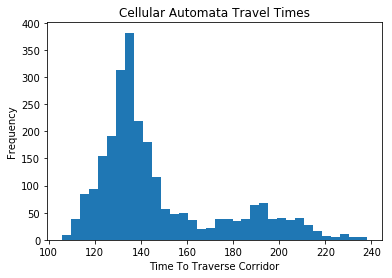

2530


In [924]:
# Preliminary Data Viz - run this box twice
deltas = calculate_deltas(data)
deltas = deltas[1000:]

import matplotlib.pyplot as plt
plt.hist(deltas, bins='auto')
plt.title("Cellular Automata Travel Times")
plt.xlabel("Time To Traverse Corridor")
plt.ylabel("Frequency")
plt.show()

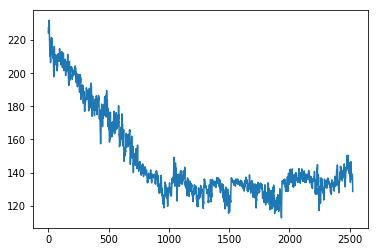

In [925]:
#Moving Average
import scipy.stats as stats
bin_size = 3
k = int(bin_size-1 / 2)
d2 = stats.binned_statistic(deltas, deltas, bins=100)[0]

def moving_avg(data, periods=5):
    weights = np.ones(periods) / periods
    return np.convolve(data, weights, mode='valid')

ma = moving_avg(deltas)
plt.plot(ma)
plt.show()
    

In [926]:
# Test Suite
get_max_v_unit()
get_starting_v_unit()
get_intersections_unit(0,10)
get_intersections_unit(4,200)
get_intersections_unit(5,100)
initialize_corridor_unit(200, 2, 3, .5)
initialize_corridor_unit(200, 2, 4, .5)
initialize_corridor_unit(5000, 100, 100, 1)
get_car_unit()
step_lanechange_unit()
step_movement_unit()

# If assertions don't fail, tests pass
print("Tests passed")

Tests passed
